In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
"""Utility functions for saving predictions for submission to Kaggle."""

import csv
import os

import numpy as np


def write_csv(file_path: str, y_list: np.ndarray):
    """Write a CSV file.

    Parameters:
        file_path: name of the file to save
        y_list: y predictions
    """
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    solution_rows = [("id", "category")] + [(i, y) for (i, y) in enumerate(y_list)]
    with open(file_path, "w") as f:
        writer = csv.writer(f)
        writer.writerows(solution_rows)


def output_submission_csv(output_file_path: str, y_test: np.ndarray):
    """Save predictions for Kaggle submission.

    Parameters:
        output_file_path: name of the file to save
        y_test: y predictions
    """
    write_csv(output_file_path, y_test)


In [3]:
"""Data preprocessing."""

import os
import pickle
from typing import Any, Tuple

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


def load_pickle(f: str) -> Any:
    """Load a pickle file.

    Parameters:
        f: the pickle filename

    Returns:
        the pickled data
    """
    return pickle.load(f, encoding="latin1")


def load_CIFAR_batch(filename: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Load a single batch of cifar data.

    Parameters:
        filename: the pickle filename

    Returns:
        the data
        the labels
    """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Load all of cifar data.

    Parameters:
        ROOT: the root directory containing the data

    Returns:
        training data
        training labels
        testing data
        testing labels
    """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_{}".format(b))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(
    num_training: int = 49000,
    num_validation: int = 1000,
    num_test: int = 10000,
    subtract_mean: bool = True,
):
    """Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.

    Parameters:
        num_training: number of training images
        num_validation: number of validation images
        num_test: number of test images
        subtract_mean: whether or not to normalize the data

    Returns:
        the train/val/test data and labels
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = os.path.join("/content/drive/MyDrive/CS747-assignment1/CS747-assignment1/cifar-10-python", "cifar-10-batches-py")
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
    }


In [4]:
import random
import numpy as np
#from data_process import get_CIFAR10_data
from scipy.spatial import distance

# from models import Perceptron, SVM, Softmax
# from kaggle_submission import output_submission_csv
%matplotlib inline

# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Loading CIFAR-10

In the following cells we determine the number of images for each split and load the images.
<br /> 
TRAIN_IMAGES + VAL_IMAGES = (0, 50000]
, TEST_IMAGES = 10000

In [5]:
# You can change these numbers for experimentation
# For submission we will use the default values 
TRAIN_IMAGES = 40000
VAL_IMAGES = 10000

In [6]:
data = get_CIFAR10_data(TRAIN_IMAGES, VAL_IMAGES)
X_train_CIFAR, y_train_CIFAR = data['X_train'], data['y_train']
X_val_CIFAR, y_val_CIFAR = data['X_val'], data['y_val']
X_test_CIFAR, y_test_CIFAR = data['X_test'], data['y_test']
n_class_CIFAR = len(np.unique(y_test_CIFAR))

Convert the sets of images from dimensions of **(N, 3, 32, 32) -> (N, 3072)** where N is the number of images so that each **3x32x32** image is represented by a single vector.

In [7]:
X_train_CIFAR = np.reshape(X_train_CIFAR, (X_train_CIFAR.shape[0], -1))
X_val_CIFAR = np.reshape(X_val_CIFAR, (X_val_CIFAR.shape[0], -1))
X_test_CIFAR = np.reshape(X_test_CIFAR, (X_test_CIFAR.shape[0], -1))

### Get Accuracy

This function computes how well your model performs using accuracy as a metric.

In [8]:
def get_acc(pred, y_test):
    return np.sum(y_test == pred) / len(y_test) * 100

# Perceptron

Perceptron has 2 hyperparameters that you can experiment with:
- **Learning rate** - controls how much we change the current weights of the classifier during each update. We set it at a default value of 0.5, but you should experiment with different values. We recommend changing the learning rate by factors of 10 and observing how the performance of the classifier changes. You should also try adding a **decay** which slowly reduces the learning rate over each epoch.
- **Number of Epochs** - An epoch is a complete iterative pass over all of the data in the dataset. During an epoch we predict a label using the classifier and then update the weights of the classifier according to the perceptron update rule for each sample in the training set. You should try different values for the number of training epochs and report your results.

You will implement the Perceptron classifier in the **models/perceptron.py**

The following code: 
- Creates an instance of the Perceptron classifier class 
- The train function of the Perceptron class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy


## Train Perceptron on CIFAR

In [9]:
"""Perceptron model."""

import numpy as np


from operator import add, sub
class Perceptron:
    def __init__(self, n_class: int, lr: float, epochs: int):
        """Initialize a new classifier.

        Parameters:
            n_class: the number of classes
            lr: the learning rate
            epochs: the number of epochs to train for
        """
        self.w = None
        self.lr = lr
        self.epochs = epochs
        self.n_class = n_class

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Train the classifier.

        Use the perceptron update rule as introduced in the Lecture.

        Parameters:
            X_train: a number array of shape (N, D) containing training data;
                N examples with D dimensions
            y_train: a numpy array of shape (N,) containing training labels
        """
        
        self.w = 0.001 * np.random.randn(self.n_class,X_train.shape[1])

        for _ in range(self.epochs):
          for index,row in enumerate(X_train):
            predarray = np.dot(self.w,row)
            predictclass = np.argmax(predarray)
            if predictclass != y_train[index]:
              self.w[y_train[index]] += self.lr * row
              self.w[predictclass] -= .3 *self.lr * row 
        


    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Use the trained weights to predict labels for test data points.

        Parameters:
            X_test: a numpy array of shape (N, D) containing testing data;
                N examples with D dimensions

        Returns:
            predicted labels for the data in X_test; a 1-dimensional array of
                length N, where each element is an integer giving the predicted
                class.
        """
        return np.argmax(np.dot(self.w, X_test.T),axis=0)
        

In [10]:
lr = 0.001
n_epochs = 10

percept_CIFAR = Perceptron(n_class_CIFAR, lr, n_epochs)
percept_CIFAR.train(X_train_CIFAR, y_train_CIFAR)


In [11]:
pred_percept = percept_CIFAR.predict(X_train_CIFAR)
print('The training accuracy is given by: %f' % (get_acc(pred_percept, y_train_CIFAR)))

The training accuracy is given by: 37.587500


### Validate Perceptron on CIFAR

In [12]:
pred_percept = percept_CIFAR.predict(X_val_CIFAR)
print('The validation accuracy is given by: %f' % (get_acc(pred_percept, y_val_CIFAR)))

The validation accuracy is given by: 35.360000


### Test Perceptron on CIFAR

In [13]:
pred_percept = percept_CIFAR.predict(X_test_CIFAR)
print('The testing accuracy is given by: %f' % (get_acc(pred_percept, y_test_CIFAR)))

The testing accuracy is given by: 35.510000


### Perceptron_CIFAR Kaggle Submission

Once you are satisfied with your solution and test accuracy, output a file to submit your test set predictions to the Kaggle for Assignment 1 CIFAR. Use the following code to do so:

In [14]:
output_submission_csv('kaggle/perceptron_submission_CIFAR.csv', percept_CIFAR.predict(X_test_CIFAR))

# Support Vector Machines (with SGD)

Next, you will implement a "soft margin" SVM. In this formulation you will maximize the margin between positive and negative training examples and penalize margin violations using a hinge loss.

We will optimize the SVM loss using SGD. This means you must compute the loss function with respect to model weights. You will use this gradient to update the model weights.

SVM optimized with SGD has 3 hyperparameters that you can experiment with:
- **Learning rate** - similar to as defined above in Perceptron, this parameter scales by how much the weights are changed according to the calculated gradient update. 
- **Epochs** - similar to as defined above in Perceptron.
- **Regularization constant** - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin. You could try different values. The default value is set to 0.05.

You will implement the SVM using SGD in the **models/svm.py**

The following code: 
- Creates an instance of the SVM classifier class 
- The train function of the SVM class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy

## Train SVM on CIFAR

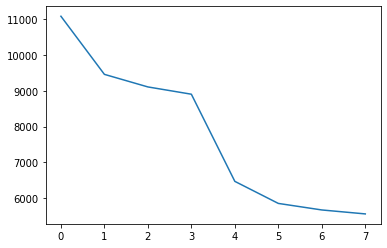

In [15]:
"""Support Vector Machine (SVM) model."""

import numpy as np

class SVM:
    def __init__(self, n_class: int, lr: float, epochs: int, reg_const: float):
        """Initialize a new classifier.

        Parameters:
            n_class: the number of classes
            lr: the learning rate
            epochs: the number of epochs to train for
            reg_const: the regularization constant
        """
        self.w = None  # TODO: change this
        self.alpha = lr
        self.epochs = epochs
        self.reg_const = reg_const
        self.n_class = n_class

    def calc_gradient(self, X_train: np.ndarray, y_train: np.ndarray) -> np.ndarray:
        """Calculate gradient of the svm hinge loss.

        Inputs have dimension D, there are C classes, and we operate on
        mini-batches of N examples.

        Parameters:
            X_train: a numpy array of shape (N, D) containing a mini-batch
                of data
            y_train: a numpy array of shape (N,) containing training labels;
                y[i] = c means that X[i] has label c, where 0 <= c < C

        Returns:
            the gradient with respect to weights w; an array of the same shape
                as w
        """
        # TODO: implement me

        loss , Number_of_rows, Number_classes , gradient = 0 , X_train.shape[0],self.w.shape[1] , np.zeros(self.w.shape)
        y_traintemp = y_train.astype(int)
        output = X_train.dot(self.w)

        for index,output in enumerate(output):
          correct_outputscore = output[y_traintemp[index]]
          gradient +=  (self.reg_const/Number_of_rows ) * self.w

          for j in range(Number_classes):
            difference = output[j]-correct_outputscore + 1
            if j != y_traintemp[index] and difference > 0:
              loss += max([0.0,difference])
              gradient[:,j] -= X_train[index].T
              gradient[:,y_traintemp[index]] += X_train[index].T
        
        loss /= Number_of_rows
        gradient /= Number_of_rows

        loss += self.reg_const * np.sum(self.w * self.w)

        return loss,gradient
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Train the classifier.

        Hint: operate on mini-batches of data for SGD.

        Parameters:
            X_train: a numpy array of shape (N, D) containing training data;
                N examples with D dimensions
            y_train: a numpy array of shape (N,) containing training labels
        """
        # TODO: implement me

        length_of_train,Dimensions = X_train.shape
        Number_of_classes = 10
        self.w = 0.001 * np.random.randn(Dimensions,Number_of_classes)

        loss_array = []

        for p in range(self.epochs):
          if p%4 == 0: 
            self.alpha /= 100
          loss = 0
          arr = np.hstack((X_train,y_train.reshape(-1,1)))
          np.random.shuffle(arr)
          X,Y = arr[:,:-1],arr[:,-1]
          start,end = 0,32

          for i in range(int(length_of_train/32)):
            x_batch,y_batch = X[start:end,],Y[start:end,]
            temploss,gradient = self.calc_gradient(x_batch,y_batch)
            loss += temploss
            self.w += self.alpha * gradient
            start+=32
            end+=32

          loss_array.append(loss)

        return loss_array

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Use the trained weights to predict labels for test data points.

        Parameters:
            X_test: a numpy array of shape (N, D) containing testing data;
                N examples with D dimensions

        Returns:
            predicted labels for the data in X_test; a 1-dimensional array of
                length N, where each element is an integer giving the predicted
                class.
        """
        # TODO: implement me

        return   np.argmax(np.dot(self.w.T,X_test.T),axis=0)


# lr = 0.0000001
# n_epochs = 20
# reg_const = .001

lr = 0.0001
n_epochs = 8
reg_const = .001

svm_CIFAR = SVM(n_class_CIFAR, lr, n_epochs, reg_const)
loss_array = svm_CIFAR.train(X_train_CIFAR, y_train_CIFAR)

import matplotlib.pyplot as plt

plt.plot(loss_array)

# loss average with 8 epochs

In [16]:
pred_svm = svm_CIFAR.predict(X_train_CIFAR)
print('The training accuracy is given by: %f' % (get_acc(pred_svm, y_train_CIFAR)))

The training accuracy is given by: 40.807500


### Validate SVM on CIFAR

In [17]:
pred_svm = svm_CIFAR.predict(X_val_CIFAR)
print('The validation accuracy is given by: %f' % (get_acc(pred_svm, y_val_CIFAR)))

The validation accuracy is given by: 36.460000


### Test SVM on CIFAR

In [18]:
pred_svm = svm_CIFAR.predict(X_test_CIFAR)
print('The testing accuracy is given by: %f' % (get_acc(pred_svm, y_test_CIFAR)))

The testing accuracy is given by: 35.630000


### SVM_CIFAR Kaggle Submission

Once you are satisfied with your solution and test accuracy output a file to submit your test set predictions to the Kaggle for Assignment 1 CIFAR. Use the following code to do so:

In [19]:
output_submission_csv('kaggle/svm_submission_CIFAR.csv', svm_CIFAR.predict(X_test_CIFAR))

# Softmax Classifier (with SGD)

Next, you will train a Softmax classifier. This classifier consists of a linear function of the input data followed by a softmax function which outputs a vector of dimension C (number of classes) for each data point. Each entry of the softmax output vector corresponds to a confidence in one of the C classes, and like a probability distribution, the entries of the output vector sum to 1. We use a cross-entropy loss on this sotmax output to train the model. 

Check the following link as an additional resource on softmax classification: http://cs231n.github.io/linear-classify/#softmax

Once again we will train the classifier with SGD. This means you need to compute the gradients of the softmax cross-entropy loss function according to the weights and update the weights using this gradient. Check the following link to help with implementing the gradient updates: https://deepnotes.io/softmax-crossentropy

The softmax classifier has 3 hyperparameters that you can experiment with:
- **Learning rate** - As above, this controls how much the model weights are updated with respect to their gradient.
- **Number of Epochs** - As described for perceptron.
- **Regularization constant** - Hyperparameter to determine the strength of regularization. In this case, we minimize the L2 norm of the model weights as regularization, so the regularization constant is a coefficient on the L2 norm in the combined cross-entropy and regularization objective.

You will implement a softmax classifier using SGD in the **models/softmax.py**

The following code: 
- Creates an instance of the Softmax classifier class 
- The train function of the Softmax class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy

## Train Softmax on CIFAR

In [20]:
"""Softmax model."""

import numpy as np

class Softmax:
    def __init__(self, n_class: int, lr: float, epochs: int, reg_const: float):
        """Initialize a new classifier.

        Parameters:
            n_class: the number of classes
            lr: the learning rate
            epochs: the number of epochs to train for
            reg_const: the regularization constant
        """
        self.w = None  # TODO: change this
        self.lr = lr
        self.epochs = epochs
        self.reg_const = reg_const
        self.n_class = n_class
     
    def calc_gradient(self, X_train: np.ndarray, y_train: np.ndarray) -> np.ndarray:
        """Calculate gradient of the softmax loss.

        Inputs have dimension D, there are C classes, and we operate on
        mini-batches of N examples.

        Parameters:
            X_train: a numpy array of shape (N, D) containing a mini-batch
                of data
            y_train: a numpy array of shape (N,) containing training labels;
                y[i] = c means that X[i] has label c, where 0 <= c < C

        Returns:
            gradient with respect to weights w; an array of same shape as w
        """
        # TODO: implement me

        y_train = y_train.astype(int)

        loss , Number_of_rows, Number_classes , gradient = 0 , X_train.shape[0],self.w.shape[1] , np.zeros(self.w.shape)
        y_traintemp = y_train.astype(int)

        output = X_train.dot(self.w)

        for index,row in enumerate(output):
          row -= max(row)
          probability = np.exp(row)/np.sum(np.exp(row))
          loss += -np.log(probability[int(y_train[index])])
          probability[int(y_train[index])] -= 1
          gradient += np.dot(X_train[index].reshape(-1,1),probability.reshape(-1,1).reshape(1,-1)) 
        
        loss /= Number_of_rows
        gradient /= Number_of_rows

        loss += self.reg_const * np.sum(self.w * self.w)
        
        return loss,gradient
    
        
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Train the classifier.

        Hint: operate on mini-batches of data for SGD.

        Parameters:
            X_train: a numpy array of shape (N, D) containing training data;
                N examples with D dimensions
            y_train: a numpy array of shape (N,) containing training labels
        """
        # TODO: implement me

        length_of_train,Dimensions = X_train.shape
        Number_of_classes = 10
        self.w = 0.001 * np.random.randn(Dimensions,Number_of_classes)

        loss_array = []

        for p in range(self.epochs):
          if p%4 == 0: 
            self.lr /= 100
          loss = 0

          arr = np.hstack((X_train,y_train.reshape(-1,1)))
          np.random.shuffle(arr)
          X,Y = arr[:,:-1],arr[:,-1]
          start,end = 0,32

          for i in range(int(length_of_train/32)):
            x_batch,y_batch = X[start:end,],Y[start:end,]
            temploss,gradient = self.calc_gradient(x_batch,y_batch)
            loss+=temploss
            self.w -= self.lr * gradient
            start+=32
            end+=32
          loss_array.append(loss)
        return loss_array

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Use the trained weights to predict labels for test data points.

        Parameters:
            X_test: a numpy array of shape (N, D) containing testing data;
                N examples with D dimensions

        Returns:
            predicted labels for the data in X_test; a 1-dimensional array of
                length N, where each element is an integer giving the predicted
                class.
        """
        # TODO: implement me

        return np.argmax(np.dot(self.w.T,X_test.T),axis=0)


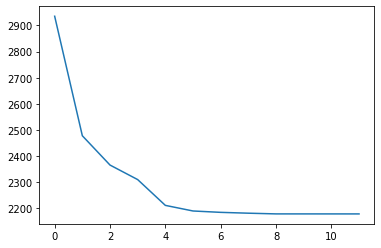

In [21]:
import matplotlib.pyplot as plt

lr = 0.0001
n_epochs = 12
reg_const = 0.001

softmax_CIFAR = Softmax(n_class_CIFAR, lr, n_epochs, reg_const)
l = softmax_CIFAR.train(X_train_CIFAR, y_train_CIFAR)

plt.plot(l)


# loss average with 8 epochs

In [22]:
pred_softmax = softmax_CIFAR.predict(X_train_CIFAR)
print('The training accuracy is given by: %f' % (get_acc(pred_softmax, y_train_CIFAR)))

The training accuracy is given by: 40.685000


### Validate Softmax on CIFAR

In [23]:
pred_softmax = softmax_CIFAR.predict(X_val_CIFAR)
print('The validation accuracy is given by: %f' % (get_acc(pred_softmax, y_val_CIFAR)))

The validation accuracy is given by: 36.980000


### Testing Softmax on CIFAR

In [24]:
pred_softmax = softmax_CIFAR.predict(X_test_CIFAR)
print('The testing accuracy is given by: %f' % (get_acc(pred_softmax, y_test_CIFAR)))

The testing accuracy is given by: 37.370000


### Softmax_CIFAR Kaggle Submission

Once you are satisfied with your solution and test accuracy output a file to submit your test set predictions to the Kaggle for Assignment 1 CIFAR. Use the following code to do so:

In [25]:
output_submission_csv('kaggle/softmax_submission_CIFAR.csv', softmax_CIFAR.predict(X_test_CIFAR))